Authors: **Christophe HAIKAL and Hugo PREVOTEAU**

# NLP Project 2

## Menu
**Our work is divided in the following parts: <br>**
[Imports](#Imports): importing libraries and data<br>
[Preprocessing](#Preprocessing): scrapping the XML file to create our dataframe

**Our two tested approaches: <br>**
[TF-IDF](#TF-IDF)<br>
[Doc2Vec](#Doc2Vec)

For this project we decided to use two different approaches, the first one would be the TF-IDF (the one from the first project) as well as a Doc2Vec model (that we also used in the first project). These two approaches provide vector representations for each document, and allows us to perform classification as well as regression tasks.

[Conclusion](#Conclusion)

# Imports

### Libraries

In [68]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

In [69]:
import warnings
warnings.filterwarnings('ignore')

### Gathering the data

In [70]:
infile = open("C:/Users/hugop/Desktop/corpus-taln/corpus_taln_v1.tei.xml","r", encoding='UTF-8')
contents = infile.read()
soup = BeautifulSoup(contents,'xml')

In [71]:
soup.bibl.clear()

# Preprocessing

#### Scrapping

*We use the XML tags to retrieve information that we want, using beaufitul soup, since XML and HTML work the same way*

*authors*

In [72]:
author = soup.find_all('text')

In [73]:
selector = {'xml:lang':["fr","en"]}
titles = soup.find_all('title', selector)

In [74]:
title = []
for x in titles:
    title.append(x.text.replace('\n',''))
title = list(dict.fromkeys(title))

In [75]:
titles_list = []
for x in titles:
    titles_list.append(str(x))

In [76]:
titles_list = list(dict.fromkeys(titles_list))

*languages*

In [77]:
language = []
for x in titles_list:
    language.append(re.search('\"(.*)\"', x).group(1))

*texts*

In [78]:
paragraphs = []
for x in author:
    paragraphs.append(BeautifulSoup(str(x), "lxml").text.replace('\n\n\n\n\n',' ').replace('\n\n\n\n',' ').replace('\n\n\n',' ').replace('\n\n',' ').replace('\n',' ').replace("\'","").replace('None ','').replace('  ',' '))

In [79]:
paragraphs_clean = []
regex = re.compile(".?((.?))")
for x in paragraphs:
    paragraphs_clean.append(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x).replace('[]', '').replace('()', '').replace('  ', ' ').replace(' .','.'))
paragraphs_clean = list(dict.fromkeys(paragraphs_clean))

*dates*

In [80]:
dates = soup.find_all('imprint') #we use this tag because its unique in each article, avoids duplicates

*conference*

In [81]:
conf = soup.find_all('fileDesc', {"xml:id": re.compile('^r|t')})

In [82]:
conf = conf[1:] ##supprimer le fileDesc qui correspond à la description du fichier xml

In [83]:
conferences = []
for x in conf:
    conferences.append(str(x).replace('-', '"'))

In [84]:
conferences_clean = []
for x in conferences:
    conferences_clean.append(re.search('\"(.*)\"', x).group(1))

In [85]:
conferences_clean_2 = []
for x in conferences_clean:
    if x[0] == 't':
        x = x[0:4]
    else:
        x = x[0:7]
    conferences_clean_2.append(x)

In [86]:
date = []
for x in dates:
    date.append(x.get_text().replace('\n',''))

*Once we scrapped all the data we can zip the lists into a single pandas dataframe that we'll use later*

In [87]:
#filling a dataframe with the scrapped data
df = pd.DataFrame(list(zip(paragraphs_clean, language,title, date,conferences_clean_2)), columns =['Text', 'Language','name', 'date', 'conference'])

In [88]:
df_fr = df[df['Language'] == 'fr'] #we focus on french papers only for this part

In [89]:
df_fr = df_fr[df_fr['Text'].str.len() > 2570] #we delete the articles with no text body

In [90]:
Counter(list(df_fr['conference']))

Counter({'taln': 1089, 'recital': 196})

#### Lowercasing the text

In [91]:
df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_fr['Text'].head()

0    nous considérons dans notre travail la tâche d...
1    nous donnons ici un aperçu du logiciel decid d...
3    le terme de lambda-drt désigne un ensemble de ...
4    dans cet article, nous comparons deux modèles ...
5    dans le cadre des approches à base de grammair...
Name: Text, dtype: object

#### Removing the stopwords

In [92]:
from nltk.corpus import stopwords
stop = stopwords.words('french')
df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_fr['Text'].head()

0    considérons travail tâche traitement automatiq...
1    donnons ici aperçu logiciel decid développé ge...
3    terme lambda-drt désigne ensemble méthodes per...
4    cet article, comparons deux modèles linguistiq...
5    cadre approches base grammaires faiblement sen...
Name: Text, dtype: object

#### Removing the punctuation

In [93]:
df_fr['Text'] = df_fr['Text'].str.replace('[^\w\s]','')

#### Lemmatization

*We didn't use this, since we think that the french lemmatizer is not good enough*

#### Stemming

In [94]:
df_fr['Text_no_stemming'] = df_fr['Text']

In [95]:
from nltk.stem.snowball import FrenchStemmer
stemmerFR = FrenchStemmer()
df_fr['Text'] = df_fr.apply(lambda x: " ".join([stemmerFR.stem(word) for word in x['Text'].split()]), axis = 1)

In [96]:
df_fr['Text'].head()

0    considéron travail tâch trait automat vis cons...
1    donnon ici aperçu logiciel decid développ get ...
3    term lambdadrt désign ensembl méthod permet co...
4    cet articl comparon deux model linguist utilis...
5    cadr approch bas grammair faibl sensibl contex...
Name: Text, dtype: object

In [97]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 

In [98]:
CountFrequency(sorted(pd.to_numeric(df_fr['date'])))

 1997 :  2
 1998 :  12
 1999 :  31
 2000 :  13
 2001 :  29
 2002 :  47
 2003 :  45
 2004 :  65
 2005 :  66
 2006 :  63
 2007 :  81
 2008 :  62
 2009 :  96
 2010 :  85
 2011 :  95
 2012 :  69
 2013 :  59
 2014 :  86
 2015 :  78
 2016 :  45
 2017 :  52
 2018 :  68
 2019 :  36


# TF-IDF

We start with the TD-IDF, that will provide vectors for the documents. One of the main pros of TF-IDF is that it automatically deletes the stopwords relative to the papers themselves (for example talking about NLP, the word "corpus" may be a stopword, since it appears in almost all of the documents). On the other hand the french stopwords from the NLTK library are not as great as the english ones, one more reason to rely on the TF-IDF.

In [99]:
from sklearn.utils import shuffle
df_fr = shuffle(df_fr, random_state=1)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,
                                 use_idf=True, ngram_range=(1,1), stop_words=['proceedings','proceeding'])

%time tfidf_matrix = tfidf_vectorizer.fit_transform(list(df_fr['Text'])) #fit the vectorizer to reviews
print(tfidf_matrix.shape)

Wall time: 2.41 s
(1285, 849)


In [101]:
a = tfidf_matrix.toarray()
a = a.tolist()

X_train = a[:1000]
y_train = list(df_fr['date'])[:1000]
X_test = a[1000:]
y_test = list(df_fr['date'])[1000:]

In [102]:
a = []
for item in y_train:
    a.append(float(item))
    
y_train = a


a = []
for item in y_test:
    a.append(float(item))
    
y_test = a

### Dummy Classifier (as baseline)

We use the Dummy Classifier as a beseline for our classification methods. The dummy classifier is a naive method that always predicts the most frequent class (hence, maximizing the performance of a naive classifier).

In [44]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

So here we can see that our Dummy Classifier gets 7.36% of accuracy

In [45]:
dummy_clf.score(X_test, y_test)

0.07368421052631578

### KNN

We try using the KNN for classification, a very simple algorithm that usually performs fine

In [184]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,40,2)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

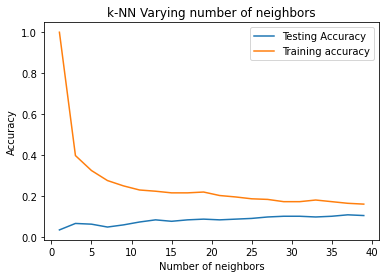

In [185]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We achieved a slightly better score with the KNN, it outperforms the Dummy Classifier, but not by much with only 12.28% of accuracy

In [186]:
max(test_accuracy)

0.10877192982456141

In [187]:
#which iteration is the best:
(list(test_accuracy).index(max(test_accuracy))*2)+1

37

In [188]:
np.random.seed(1)

### Classifiers

As we notice the KNN does not perform as well as we wanted, we try all the available classification algorithms in the Scikit-Learn library. This method is very efficient in the way that it allows testing a lot of algorithms but is not perfect: we test each algorithm with the default configuration. Which means that to us, the algorithms with pretty good default parameters (for our dataset) will perform well compared to other methods with worse default parameters but that can be tuned to get a better accuracy. However one of the solutions against this would be to perform a grid search for each one of the classification algorithm, hence getting the real best algorithm in our case.

In [189]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='classifier')

all_clfs = []
for name, ClassifierClass in estimators:
    #print('Appending', name)
    try:
        clf = ClassifierClass()
        all_clfs.append(clf)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

__init__() missing 1 required positional argument: 'base_estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimators'
__init__() missing 1 required positional argument: 'estimators'


In [190]:
results = []
for algo in all_clfs:
    try:
        algo.fit(X_train, y_train)
        performance = algo.score(X_test, y_test)
        results.append(performance)
        print(performance)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

0.08771929824561403
0.14736842105263157
0.11929824561403508
0.11578947368421053
0.07368421052631578
0.08070175438596491
0.12982456140350876
0.07368421052631578
0.07368421052631578
0.14035087719298245
0.10175438596491228
0.10175438596491228
0.09473684210526316
0.14385964912280702
0.06315789473684211
0.03508771929824561
0.03859649122807018
0.042105263157894736
0.07017543859649122
0.09473684210526316
0.07017543859649122
0.08070175438596491
0.10526315789473684
0.07719298245614035
specified nu is infeasible
0.06315789473684211
0.07719298245614035
0.0035087719298245615
No neighbors found for test samples array([  1,   6,   7,   8,  10,  11,  14,  16,  18,  28,  31,  48,  49,
        54,  58,  59,  60,  66,  74,  76,  77,  81,  82,  88,  90,  91,
       106, 121, 124, 135, 146, 155, 157, 160, 161, 165, 170, 176, 177,
       183, 197, 198, 203, 217, 222, 229, 235, 244, 262, 263, 264, 272,
       283], dtype=int64), you can try using larger radius, giving a label for outliers, or considering re

Here we can see the best algorithm of all of them, performing 17.54% of accuracy

In [191]:
all_clfs[results.index(max(results))]

BaggingClassifier()

### Dummy Regressor (as baseline)

Seeing that the classification algorithms perform poorly on this dataset we chose to switch to a regression approach: we can predict a float between 1997 and 2019 then round the number to the closest integer, hence getting a classification if we want.

We first perform the dummy regressor to get the baseline for our regression models

In [36]:
import numpy as np
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.score(X_test, y_test)

-0.0032957216915714405

In [37]:
y_pred = dummy_regr.predict(X_test)

We get a MSE of 26 with the dummy regressor

In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

26.732491807017574

In [195]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='regressor')

all_regs = []
for name, ClassifierClass in estimators:
    #print('Appending', name)
    try:
        clf = ClassifierClass()
        all_regs.append(clf)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'base_estimator'
__init__() missing 1 required positional argument: 'estimators'
__init__() missing 1 required positional argument: 'estimators'


I had to stop the cell from running cause it was way too long, don't really know why

In [196]:
results_regs = []
for algo in all_regs:
    try:
        algo.fit(X_train, y_train)
        performance = algo.score(X_test, y_test)
        results.append(performance)
        print(performance)
    except Exception as e:
        print(e)

0.21472528538602476
0.3925030802651095
0.3025470310107716
0.43743107871773657
-0.2283519784138861
-0.07934145015175642
-0.001385750811327524
-0.001385750811327524
0.4446741141969849
-0.25863633208251535
0.4320230920045345
-0.0013854894201472678
-2.24809687465523
0.41561971709032175
0.42548531615460916
0.13790167028582845
Isotonic regression input X should be a 1d array or 2d array with 1 feature
0.24005898641326606
-3213.9010161027704
-1.3821997058455286
0.37110911505607946
-0.001385750811327524
0.44727130231680046
-0.001385750811327524
0.452817858134569
0.37804332912157046
-2.237326752920066
-27035.200341161075
-33981.43932293607
For mono-task outputs, use ElasticNet
For mono-task outputs, use ElasticNetCVCV
For mono-task outputs, use ElasticNet
For mono-task outputs, use LassoCVCV
0.2588807176891601
0.28713971326354426
0.3132274814609456
-9.573772574889984
0.44283119674092064
0.1396656482805827
0.43581026692117786
-56.990047751394066
Input contains NaN, infinity or a value too large 

KeyboardInterrupt: 

We try the two best regression method using the same approach to try all the regressors fro Scikit-Learn library

### Gradient Boosting Regressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=1)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.44202319914570065

We get a MSE of 15.01, better than the Dummy Regressor

In [42]:
for i in range(len(y_pred)):
    if y_pred[i] > 2019:
        y_pred[i] = 2019
    if y_pred[i] < 1997:
        y_pred[i] = 1997

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

14.863130406331823

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,200,300,400,500], 
            'learning_rate': [0.025,0.05,0.075,0.1],
            'max_depth':[4,5,6], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

reg = GradientBoostingRegressor(random_state=1)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.025, 0.05, 0.075, 0.1],
                         'max_depth': [4, 5, 6], 'max_features': [1.0],
                         'min_samples_leaf': [3],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

In [46]:
y_pred = grid_search.predict(X_test)
grid_search.score(X_test, y_test)

0.4714774554586725

We have a MSE of 14

In [49]:
for i in range(len(y_pred)):
    if y_pred[i] > 2019:
        y_pred[i] = 2019
    if y_pred[i] < 1997:
        y_pred[i] = 1997

In [50]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

14.074983510893242

### Hist Gradient Boosting Regressor

In [51]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
est = HistGradientBoostingRegressor().fit(X_train, y_train)
est.score(X_test, y_test)

0.42548531615460916

We have a MSE of 14.6 too 

In [53]:
y_pred = est.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

14.672323444954957

### Multi-layer Perceptron regressor

In [54]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=500, random_state=1, max_iter=200000).fit(X_train, y_train)
y_pred = regr.predict(X_test)
regr.score(X_test, y_test)

-198.36318593195455

In [55]:
a = tfidf_matrix.toarray()
a = a.tolist()

X_train = a
y_train = list(df_fr['date'])

a = []
for item in y_train:
    a.append(float(item))
    
y_train = a

In [71]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense

In [72]:
X_train = numpy.array(X_train)
y_train = numpy.array(y_train)

In [73]:
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 849)               721650    
_________________________________________________________________
dense_1 (Dense)              (None, 2670)              2269500   
_________________________________________________________________
dense_2 (Dense)              (None, 2670)              7131570   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2671      
Total params: 10,125,391
Trainable params: 10,125,391
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train, batch_size=80, epochs=150, verbose=1, validation_split=0.2)
#predictions = model.predict(X_test)

Epoch 1/150
13/13 [==============================] - 1s 80ms/step - loss: 3385669.7500 - mse: 3385669.5000 - mae: 1823.7772 - val_loss: 866231.6875 - val_mse: 866231.6875 - val_mae: 915.4318
Epoch 2/150
13/13 [==============================] - 1s 70ms/step - loss: 445766.6875 - mse: 445766.6875 - mae: 554.6404 - val_loss: 432145.0000 - val_mse: 432145.0000 - val_mae: 625.9157
Epoch 3/150
13/13 [==============================] - 1s 70ms/step - loss: 246234.2031 - mse: 246234.2031 - mae: 419.9730 - val_loss: 139544.4531 - val_mse: 139544.4531 - val_mae: 305.5433
Epoch 4/150
13/13 [==============================] - 1s 70ms/step - loss: 120356.7422 - mse: 120356.7422 - mae: 283.4302 - val_loss: 72900.4375 - val_mse: 72900.4375 - val_mae: 219.0452
Epoch 5/150
13/13 [==============================] - 1s 69ms/step - loss: 86224.7500 - mse: 86224.7500 - mae: 235.3320 - val_loss: 80417.0000 - val_mse: 80417.0000 - val_mae: 225.7081
Epoch 6/150
13/13 [==============================] - 1s 69ms/st

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


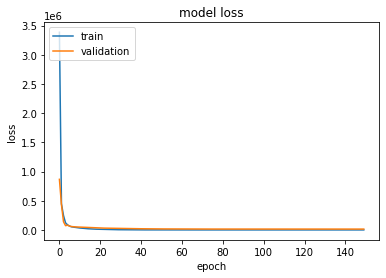

In [75]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Doc2Vec

We try a second approach, we replace the TF-IDF by the Doc2Vec, a deep learning approach that computes a vector for each text. Thanks to these vectors, called embeddings, we can compare whole documents together. We will use this method and see if it outperforms the TF-IDF approach

We use the same methods as before, hence only the results will be discussed.

In [76]:
gensim

<module 'gensim' from 'C:\\Users\\hugop\\anaconda3\\lib\\site-packages\\gensim\\__init__.py'>

In [77]:
 def LL_to_TGdoc(file=list(df_fr['Text']), tokens_only=False):
    
    for i, tokens in enumerate(file):
        if tokens_only:
                yield tokens
        else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        
train_corpus = list(LL_to_TGdoc())        

In [78]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model = Doc2Vec(train_corpus, vector_size=500, window=8, min_count=10, workers=4)

In [79]:
len(model.docvecs.doctag_syn0)

1285

In [80]:
a = model.docvecs.doctag_syn0
a = a.tolist()

X_train = a[:1000]
y_train = list(df_fr['date'])[:1000]
X_test = a[1000:]
y_test = list(df_fr['date'])[1000:]

In [81]:
a = []
for item in y_train:
    a.append(float(item))
    
y_train = a


a = []
for item in y_test:
    a.append(float(item))
    
y_test = a

### Dummy Classifier (as baseline)

In [82]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

We get an accuracy of 7.36% with the Dummy Classifier. This score being lower than the one we got with the Dummy on the TF-IDF data, we can expect the Doc2Vec approach to be worse overall.

In [83]:
dummy_clf.score(X_test, y_test)

0.07368421052631578

### KNN

In [84]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,40,2)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

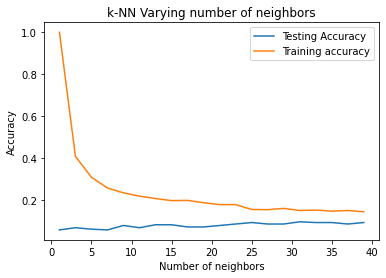

In [85]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We get an accuracy of 9.8% with the KNN

In [86]:
max(test_accuracy)

0.09824561403508772

In [87]:
#which iteration is the best:
(list(test_accuracy).index(max(test_accuracy))*2)+1

31

In [88]:
np.random.seed(1)

### Classifiers

In [89]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='classifier')

all_clfs = []
for name, ClassifierClass in estimators:
    #print('Appending', name)
    try:
        clf = ClassifierClass()
        all_clfs.append(clf)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

__init__() missing 1 required positional argument: 'base_estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'estimators'
__init__() missing 1 required positional argument: 'estimators'


In [90]:
results = []
for algo in all_clfs:
    try:
        algo.fit(X_train, y_train)
        performance = algo.score(X_test, y_test)
        results.append(performance)
        print(performance)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

0.07017543859649122
0.07368421052631578
0.08070175438596491
0.0912280701754386
Negative values in data passed to CategoricalNB (input X)
Negative values in data passed to ComplementNB (input X)
0.07017543859649122
0.07368421052631578
0.05263157894736842
0.056140350877192984
0.07368421052631578
0.08421052631578947
0.05263157894736842
0.07017543859649122
0.06315789473684211
0.05964912280701754
0.06315789473684211
0.04912280701754386
0.08421052631578947
0.09824561403508772
0.08771929824561403
0.09473684210526316
Negative values in data passed to MultinomialNB (input X)
0.08070175438596491
specified nu is infeasible
0.08070175438596491
0.05263157894736842
0.05263157894736842
No neighbors found for test samples array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  

In [99]:
max(results)

0.09824561403508772

In [112]:
import numpy as np
from sklearn.linear_model import SGDClassifier
mod = SGDClassifier()
mod.fit(X_train, y_train)
mod.score(X_test, y_test)

0.0912280701754386

In [114]:
y_pred = mod.predict(X_test)

We get a 33 of MSE with the best model availble for classification, not any better than with the TF-IDF

In [115]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

33.256140350877196

### Dummy Regressor (as baseline)

Again, we look at the regression methods

In [117]:
import numpy as np
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.score(X_test, y_test)

-0.001385750811327524

In [118]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

33.256140350877196

In [119]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='regressor')

all_regs = []
for name, ClassifierClass in estimators:
    #print('Appending', name)
    try:
        clf = ClassifierClass()
        all_regs.append(clf)
    except Exception as e:
        #print('Unable to import', name)
        print(e)

__init__() missing 1 required positional argument: 'estimator'
__init__() missing 1 required positional argument: 'base_estimator'
__init__() missing 1 required positional argument: 'estimators'
__init__() missing 1 required positional argument: 'estimators'


I had to stop the cell from running cause it was way too long, don't really know why

In [120]:
results_regs = []
for algo in all_regs:
    try:
        algo.fit(X_train, y_train)
        performance = algo.score(X_test, y_test)
        results.append(performance)
        print(performance)
    except Exception as e:
        print(e)

0.1794208786297632
0.17291238758658956
0.12192083306015922
0.2070590333735608
0.004455394025421278
-0.752968121497742
-0.001385750811327524
-0.001385750811327524
0.20548353050792356
-0.8858249420548638
0.22279000407833427
0.12663618068533244
-38231.551483496696
0.15576724809857678
0.0976254204373056
0.11367093167210507
Isotonic regression input X should be a 1d array or 2d array with 1 feature
0.015447151336110854
-2604.597014422334
-5560753.258073808
0.1289904534227041
-0.001385750811327524
0.2079607623073092
-0.001385750811327524
0.19374231835660893
0.19383250400952723
-2.2129588357310146
-8797.369557183014
-22346.037135014925
For mono-task outputs, use ElasticNet
For mono-task outputs, use ElasticNetCVCV
For mono-task outputs, use ElasticNet
For mono-task outputs, use LassoCVCV
0.2367780465126712
0.13092302091289765
0.16887027863540638
-29.099456838501446
0.20005668466530335
-0.568533045497823
0.17662194370935225
-204.3455302126896
Input contains NaN, infinity or a value too large f

KeyboardInterrupt: 

### Gradient Boosting Regressor

In [121]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=1)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.16051294344183276

In [122]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

21.439357370697504

In [123]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,200,300,400,500], 
            'learning_rate': [0.1,0.025,0.05,0.075,0.1],
            'max_depth':[4,5,6], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

reg = GradientBoostingRegressor(random_state=1)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.025, 0.05, 0.075, 0.1],
                         'max_depth': [4, 5, 6], 'max_features': [1.0],
                         'min_samples_leaf': [3],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

In [124]:
y_pred = grid_search.predict(X_test)
grid_search.score(X_test, y_test)

0.19936215384251366

In [125]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

20.44720138825216

### Hist Gradient Boosting Regressor

In [126]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
est = HistGradientBoostingRegressor().fit(X_train, y_train)
est.score(X_test, y_test)

0.0976254204373056

In [52]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

param_grid={'learning_rate': [0.05,0.1],
            'max_iter':[100,200], 
            'max_leaf_nodes':[10,20,40,50], 
            'min_samples_leaf':[10,30] } 

reg = HistGradientBoostingRegressor(random_state=1)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_iter': [100, 200],
                         'max_leaf_nodes': [10, 20, 40, 50],
                         'min_samples_leaf': [10, 30]},
             verbose=2)

In [127]:
y_pred = est.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

23.04541915487773

### Multi-layer Perceptron regressor

In [128]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=500, random_state=1, max_iter=20000).fit(X_train, y_train)
y_pred = regr.predict(X_test)
regr.score(X_test, y_test)

-3.14469607945136

In [129]:
a = tfidf_matrix.toarray()
a = a.tolist()

X_train = a
y_train = list(df_fr['date'])

a = []
for item in y_train:
    a.append(float(item))
    
y_train = a

In [130]:
X_train = numpy.array(X_train)
y_train = numpy.array(y_train)

In [131]:
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 849)               721650    
_________________________________________________________________
dense_5 (Dense)              (None, 2670)              2269500   
_________________________________________________________________
dense_6 (Dense)              (None, 2670)              7131570   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2671      
Total params: 10,125,391
Trainable params: 10,125,391
Non-trainable params: 0
_________________________________________________________________


We can see here that our model performed quite poorly, and it could be for many reasons. One of the main reasons we could think of is that we have too few data (indeed 1000 is extremely low to train deep learning models). This dataset being very small we can imagine that there is too few example of each kind for the model to learn how to predict them properly (what caracterizes them), no matter how much epochs we perform, since the problem comes from the relationship between dimensions that cannot be discovered. 

In [132]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train, batch_size=80, epochs=150, verbose=1, validation_split=0.2)
#predictions = model.predict(X_test)

Epoch 1/150
13/13 [==============================] - 1s 109ms/step - loss: 3313927.7500 - mse: 3313928.0000 - mae: 1799.7444 - val_loss: 651141.5000 - val_mse: 651141.4375 - val_mae: 784.6620
Epoch 2/150
13/13 [==============================] - 1s 93ms/step - loss: 397786.7188 - mse: 397786.7188 - mae: 519.4692 - val_loss: 415035.6875 - val_mse: 415035.6875 - val_mae: 611.2809
Epoch 3/150
13/13 [==============================] - 1s 91ms/step - loss: 218622.5781 - mse: 218622.5781 - mae: 395.8951 - val_loss: 112576.6016 - val_mse: 112576.6016 - val_mae: 274.9587
Epoch 4/150
13/13 [==============================] - 1s 94ms/step - loss: 108639.6328 - mse: 108639.6328 - mae: 269.6002 - val_loss: 82123.4297 - val_mse: 82123.4297 - val_mae: 233.5014
Epoch 5/150
13/13 [==============================] - 1s 92ms/step - loss: 79602.3359 - mse: 79602.3359 - mae: 224.9866 - val_loss: 69843.0625 - val_mse: 69843.0625 - val_mae: 210.3862
Epoch 6/150
13/13 [==============================] - 1s 102ms/

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


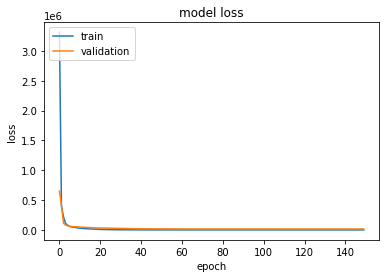

In [133]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### AutoKeras

We then tried to launch a AutoKeras model, iterating through 100 models trying to fine tune the hyper parameters. However, we thing that this technique is quite wrong since we select a model (and more particularly an epoch of the model) as being the best regarding the MSE on the validation set. This set being pretty small in our dataset (only 20% of the training set) we got super good results on the MSE of the model, however while testing on the testing set we created, it performed poorly.

In [54]:
### Gathering the data

infile = open("C:/Users/hugop/Desktop/corpus-taln/corpus_taln_v1.tei.xml","r", encoding='UTF-8')
contents = infile.read()
soup = BeautifulSoup(contents,'xml')

soup.bibl.clear()

# Preprocessing

#### Scrapping

#*We use the XML tags to retrieve information that we want, using beaufitul soup, since XML and HTML work the same way*

#*authors*

author = soup.find_all('text')

selector = {'xml:lang':["fr","en"]}
titles = soup.find_all('title', selector)

title = []
for x in titles:
    title.append(x.text.replace('\n',''))
title = list(dict.fromkeys(title))

titles_list = []
for x in titles:
    titles_list.append(str(x))

titles_list = list(dict.fromkeys(titles_list))

#*languages*

language = []
for x in titles_list:
    language.append(re.search('\"(.*)\"', x).group(1))

#*texts*

paragraphs = []
for x in author:
    paragraphs.append(BeautifulSoup(str(x), "lxml").text.replace('\n\n\n\n\n',' ').replace('\n\n\n\n',' ').replace('\n\n\n',' ').replace('\n\n',' ').replace('\n',' ').replace("\'","").replace('None ','').replace('  ',' '))

paragraphs_clean = []
regex = re.compile(".?((.?))")
for x in paragraphs:
    paragraphs_clean.append(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x).replace('[]', '').replace('()', '').replace('  ', ' ').replace(' .','.'))
paragraphs_clean = list(dict.fromkeys(paragraphs_clean))

#*dates*

dates = soup.find_all('imprint') #we use this tag because its unique in each article, avoids duplicates

#*conference*

conf = soup.find_all('fileDesc', {"xml:id": re.compile('^r|t')})

conf = conf[1:] ##supprimer le fileDesc qui correspond à la description du fichier xml

conferences = []
for x in conf:
    conferences.append(str(x).replace('-', '"'))

conferences_clean = []
for x in conferences:
    conferences_clean.append(re.search('\"(.*)\"', x).group(1))

conferences_clean_2 = []
for x in conferences_clean:
    if x[0] == 't':
        x = x[0:4]
    else:
        x = x[0:7]
    conferences_clean_2.append(x)

date = []
for x in dates:
    date.append(x.get_text().replace('\n',''))

#*Once we scrapped all the data we can zip the lists into a single pandas dataframe that we'll use later*

#filling a dataframe with the scrapped data
df = pd.DataFrame(list(zip(paragraphs_clean, language,title, date,conferences_clean_2)), columns =['Text', 'Language','name', 'date', 'conference']) 

df_fr = df[df['Language'] == 'fr'] #we focus on french papers only for this part

df_fr = df_fr[df_fr['Text'].str.len() > 2570] #we delete the articles with no text body

Counter(list(df_fr['conference']))

#### Lowercasing the text

df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_fr['Text'].head()

#### Removing the stopwords

from nltk.corpus import stopwords
stop = stopwords.words('french')
df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_fr['Text'].head()

#### Removing the punctuation

df_fr['Text'] = df_fr['Text'].str.replace('[^\w\s]','')

#### Lemmatization

#### Stemming

df_fr['Text_no_stemming'] = df_fr['Text']

from nltk.stem.snowball import FrenchStemmer
stemmerFR = FrenchStemmer()
df_fr['Text'] = df_fr.apply(lambda x: " ".join([stemmerFR.stem(word) for word in x['Text'].split()]), axis = 1)

df_fr['Text'].head()

from collections import Counter
sorted(list(df_fr['date']))

def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 

CountFrequency(sorted(pd.to_numeric(df_fr['date'])))

 1997 :  2
 1998 :  12
 1999 :  31
 2000 :  13
 2001 :  29
 2002 :  47
 2003 :  45
 2004 :  65
 2005 :  66
 2006 :  63
 2007 :  81
 2008 :  62
 2009 :  96
 2010 :  85
 2011 :  95
 2012 :  69
 2013 :  59
 2014 :  86
 2015 :  78
 2016 :  45
 2017 :  52
 2018 :  68
 2019 :  36


In [55]:
from sklearn.utils import shuffle
df_fr = shuffle(df_fr)

In [56]:
a = np.array(list(df_fr['Text']))

X_train = a[:1000]
y_train = np.array(list(df_fr['date']))[:1000]
X_test = a[1000:]
y_test = np.array(list(df_fr['date']))[1000:]
print(X_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)
print(X_train[0][:50])  # <START> this film was just brilliant casting <UNK>

(1000,)
(1000,)
cet articl présent appliqu doutil méthod trait aut


In [57]:
a = []
for item in y_train:
    a.append(float(item))


y_train = np.array(a)

In [58]:
a = []
for item in y_test:
    a.append(float(item))


y_test = np.array(a)

In [66]:
import autokeras as ak

AttributeError: module 'kerastuner' has no attribute 'engine'

In [67]:
import autokeras as ak

# Initialize the text regressor.
reg = ak.TextRegressor(
    overwrite=True,
    max_trials=10) # It tries 100 different models.
# Feed the text regressor with training data.
reg.fit(X_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))

AttributeError: module 'kerastuner' has no attribute 'engine'

In [ ]:
model = reg.export_model()
# summarize the loaded model
model.summary()
#model.save('model_reg.tf')

Here for instance, we get the best model with 3183 of MSE while we only get 1744 on the testing set. We can see here that however this SME is pretty bad, it is highly imprecise. It is due to the low size of the training and testing sets sue to the small size of the corpus.

In [143]:
y_pred = model.predict(X_test)

In [144]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=True)

1744.512867095805

# Conclusion

To conclude this work, we can say that the TF-IDF outperformed the Doc2Vec approach, despite being pretty old. It's ability to filter the texts and the low complexity of the vectors it creates probably helps models to understand the relationships between dimensions (here words). It is particularly performant since we ran it on the whole texts, previously stemmed, giving the computed frequencies even more meaning.

About the prediction models, we can see that regression models seem to outperform classification model (even though it's hard to compare them) since they are able to model the years and not just different classes like a classification algorithm would do.

Also, we saw that models that require few data to train performed better

In [104]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [107]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 